In [1]:
import torch
import pandas as pd
import os

import Utils.Data.DataLoading as DataLoading
import Utils.EvaluationMetrics.TSNEVisual as TSNEVisual
import Utils.PTModel.Inference as Inference

import Utils.PTModel.Models as Models

import Utils.PTModel.Losses as Losses
import numpy as np
import torch.nn as nn

MODELNAME = "TestDropLRVAE2"

In [2]:
# Loading standard train test split
TrainingData = DataLoading.LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def TrainModel(dataObj, epochs, batchSize, modelClassToTrain=Models.TileEmbeddingVAE, continueTraining=None, earlyStoppingRange=0, dropLearningRate=False):
    # dataObj = {"trainData": trainingdata, "testData": testData, "weightArray": tfidfWeightArray}

    if continueTraining == None:
        model = modelClassToTrain()
    else:
        model = continueTraining
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    imageCritierion = nn.MSELoss()
    textCritierion = Losses.WeightedBCE(dataObj["weightArray"].to(device))

    imageLossWeight = 0.9
    textLossWeight = 1.0 - imageLossWeight

    model.to(device)
    model.train()

    trainData = dataObj["trainData"]
    losses = []
    batchLosses = []
    valTextLosses = []

    for i in range(epochs):

        losses.append([])

        for j in range(0, trainData.shape[0], batchSize):

            xImages = np.array(trainData.iloc[j:j+batchSize]["image"].tolist())
            yImages = xImages[:, 16:32, 16:32, :]
            # print(xImages.shape)
            # print(yImages.shape)

            xImageBatch = torch.tensor(xImages, dtype=torch.float32)
            xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))
            xImageBatch = xImageBatch.to(device)

            yImageBatch = torch.tensor(yImages, dtype=torch.float32)
            yImageBatch = yImageBatch.reshape((-1, 3, 16, 16))
            yImageBatch = yImageBatch.to(device)
            
            xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)

            yPredImages, yPredTexts = model(xImageBatch, xTextbatch)
            # print(yPredImages.shape)
            # print(yImageBatch.shape)

            imageLoss = imageCritierion(yPredImages, yImageBatch)
            textLoss = textCritierion(yPredTexts, xTextbatch)
            # print(imageLoss)
            # print(textLoss)

            loss = torch.add(torch.mul(imageLoss, imageLossWeight), torch.mul(textLoss, textLossWeight))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        batchLosses.append(sum(losses[i])/len(losses[i]))

        valTrueData = torch.tensor(dataObj["testData"]["encodedAffordances"].to_list(), dtype=torch.float32).to(device)
        valPredData = torch.tensor(Inference.ModelInference(model, dataObj["testData"], clampTextOutput=False)[1], dtype=torch.float32).to(device)
        valTextLoss = textCritierion(valPredData, valTrueData)

        valTextLosses.append(valTextLoss)

        print(f"Epoch {i}: loss {batchLosses[i]} | Val Text Loss: {valTextLoss}")

        if earlyStoppingRange > 0 and i > earlyStoppingRange - 1:
            # print("In Early Stopping check")
            # print(batchLosses[-earlyStoppingRange:])
            # print(sum(batchLosses[-earlyStoppingRange:]) / earlyStoppingRange)
            # print(batchLosses[(-earlyStoppingRange)-1])
            if valTextLosses[-1] > valTextLosses[(-earlyStoppingRange)-1]:
                print("Early Stopping...")
                return model
        
        if dropLearningRate and i > 5 - 1:

            if sum(valTextLosses[-5:]) / 5 > valTextLosses[(-5)-1]:
                print("Dropping Learning Rate...")
                for g in optimizer.param_groups:
                    g['lr'] /= 10
                
                dropLearningRate = False
                    
    
    return model

In [4]:
#model = Training.TrainModel(TrainingData, 1, 32, Models.TileEmbeddingVAE)
model = TrainModel(TrainingData, 25, 32, Models.TileEmbeddingVAE, dropLearningRate=True, earlyStoppingRange=2)

/tmp/ipykernel_2409/2748746432.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)


Epoch 0: loss 7143.919912334869 | Val Text Loss: 272.3909912109375


KeyboardInterrupt: 

In [41]:
if os.path.isdir(f"Models/{MODELNAME}"):
    raise RuntimeError(f"Folder for model {MODELNAME} already exists. Delete the folder and retry or change the model name.")

os.mkdir(f"Models/{MODELNAME}")
torch.save(model, f"Models//{MODELNAME}/{MODELNAME}.pt")

In [42]:
Inference.SaveUnifiedRepresentation(model, pd.concat([TrainingData["trainData"], TrainingData["testData"]]), MODELNAME)

In [43]:
data, fitEmbeddings = TSNEVisual.TrainTSNEModel(MODELNAME)

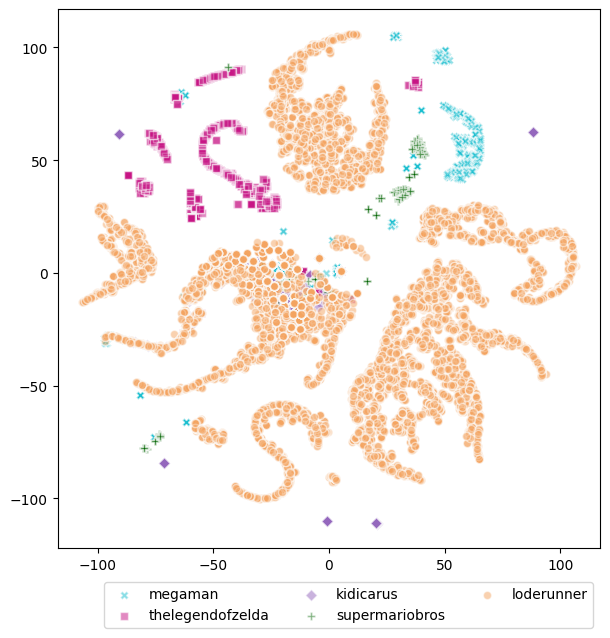

In [44]:
TSNEVisual.DisplayTSNEEmbeddings(data, fitEmbeddings, modelName=MODELNAME, save=True)